MODELO PREDITIVO DE TAXIS USANDO BIG-QUERY + TENSORFLOW

Neste notebook, se desenvolverá um modelo preditivo de Machine Learning para predizer
a demanda dos taxis no centro de Nova York

1) Recopilação de dados históricos usando BigQuery

In [2]:
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
import shutil

In [3]:
%bq tables describe --name bigquery-public-data.new_york.tlc_yellow_trips_2015

2) Análise Exploratório da demanda dos taxis

In [4]:
%bq query
SELECT 
  EXTRACT (DAYOFYEAR from pickup_datetime) AS daynumber
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2015` 
LIMIT 10

daynumber
301
178
308
336
150
74
15
229
214
237


3) Transformação de dados obtidos pela consulta BigQuery para DataFrame - TaxisDataSet

In [5]:
%bq query -n taxiquery
with trips as (
  select extract(dayofyear from pickup_datetime) as daynumber
  from `bigquery-public-data.new_york.tlc_yellow_trips_*`
  where _TABLE_SUFFIX = @YEAR
)
select daynumber, count(1) as numtrips
from trips 
group by daynumber 
order by daynumber


In [6]:
query_parameters = [
  {
    'name' : 'YEAR', 
    'parameterType'  : {'type'  : 'STRING'},
    'parameterValue' : {'value' : 2015} 
  }
]
trips = taxiquery.execute(query_params = query_parameters).result().to_dataframe()
trips[:10]

,daynumber,numtrips
0,1,382014
1,2,345296
2,3,406769
3,4,328848
4,5,363454
5,6,384324
6,7,429653
7,8,450920
8,9,447947
9,10,515540


4) Brenchmark Estatístico [Cálculo da media]

In [7]:
avg = round(np.mean(trips['numtrips']), 5)
rmse = round(np.sqrt(np.mean((trips['numtrips'] - avg)**2)), 5)
print('Avg: ' + str(avg))
print('RMSE: ' + str(rmse))

Avg: 400309.5589
RMSE: 51613.65169


5) Análise Exploratório de dados climáticos

In [8]:
%bq tables describe --name bigquery-public-data.noaa_gsod.stations

In [9]:
%bq query
select *
from `bigquery-public-data.noaa_gsod.stations`
where state = 'NY' and wban != '99999' and name like '%LA GUARDIA%'

usaf,wban,name,country,state,call,lat,lon,elev,begin,end
725030,14732,LA GUARDIA AIRPORT,US,NY,KLGA,40.779,-73.88,+0003.4,19730101,20180604


In [10]:
%bq tables describe --name bigquery-public-data.noaa_gsod.gsod2015

6) Transformação dos dados obtidos x consulta BigQuery para DataFrame - ClimaDataSet

In [11]:
%bq query -n wxquery
select extract(dayofyear from cast(concat(@YEAR, '-', mo, '-', da) as timestamp)) as daynumber, 
  min(extract(dayofweek from cast(concat(@YEAR, '-', mo, '-', da) as timestamp))) as dayofweek, 
  min(min) as mintemp, max(max) as maxtemp, max(if(prcp=99.99, 0, prcp)) as rain
from `bigquery-public-data.noaa_gsod.gsod*`
where stn = '725030' and _TABLE_SUFFIX = @YEAR
group by 1
order by daynumber desc

In [12]:
query_parameters = [
  {
    'name' : 'YEAR', 
    'parameterType'  : {'type'  : 'STRING'},
    'parameterValue' : {'value' : 2015}
  }
]

weather = wxquery.execute(query_params = query_parameters).result().to_dataframe()
weather[:10]

,daynumber,dayofweek,mintemp,maxtemp,rain
0,365,5,46.0,48.2,0.17
1,364,4,34.0,48.0,0.13
2,363,3,33.8,46.9,0.37
3,362,2,39.0,62.1,0.02
4,361,1,46.0,62.6,0.14
5,360,7,50.0,64.0,0.03
6,359,6,54.0,72.0,0.01
7,358,5,50.0,72.0,1.46
8,357,4,50.0,62.1,0.18
9,356,3,55.0,62.6,0.00


7) Criar dataset de predição merge (trips e weather)

In [13]:
data = pd.merge(trips, weather, on = 'daynumber')
data[:10]

,daynumber,numtrips,dayofweek,mintemp,maxtemp,rain
0,1,382014,5,27.0,39.0,0.00
1,2,345296,6,27.0,42.1,0.00
2,3,406769,7,30.9,42.1,0.00
3,4,328848,1,30.9,57.0,0.85
4,5,363454,2,28.9,57.0,0.13
5,6,384324,3,17.6,28.9,0.00
6,7,429653,4,15.1,25.0,0.05
7,8,450920,5,8.1,25.0,0.00
8,9,447947,6,8.1,33.1,0.00
9,10,515540,7,17.1,33.1,0.06


8) Visualização de dados

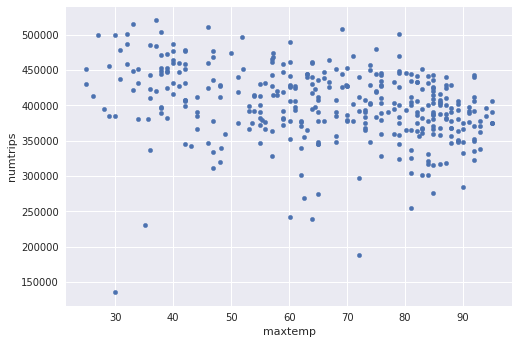

In [15]:
plot1 = data.plot(kind = 'scatter', x = 'maxtemp', y = 'numtrips')

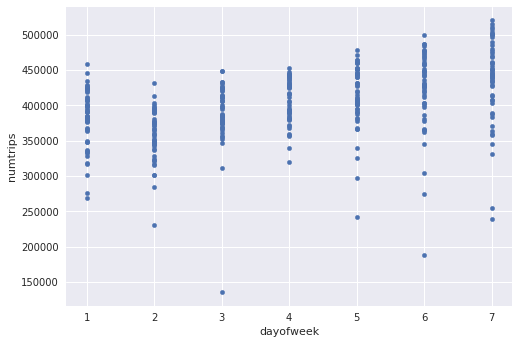

In [16]:
plot2 = data.plot(kind = 'scatter', x = 'dayofweek', y = 'numtrips')

9) Trabalhando com dados consolidados 2014, 2015, 2016

In [18]:
data2 = data
for year in [2014, 2016]:
  query_parameters = [
    {
      'name' : 'YEAR',
      'parameterType' : {'type' : 'STRING'},
      'parameterValue' : {'value' : year}
    }
  ]
  trip = taxiquery.execute(query_params = query_parameters).result().to_dataframe()
  weather = wxquery.execute(query_params = query_parameters).result().to_dataframe()
  data_for_year = pd.merge(trip, weather, on = 'daynumber')
  data2 = pd.concat([data2, data_for_year])
data2[:10]
#data2.describe()

,daynumber,numtrips,dayofweek,mintemp,maxtemp,rain
0,1,382014,5,27.0,39.0,0.00
1,2,345296,6,27.0,42.1,0.00
2,3,406769,7,30.9,42.1,0.00
3,4,328848,1,30.9,57.0,0.85
4,5,363454,2,28.9,57.0,0.13
5,6,384324,3,17.6,28.9,0.00
6,7,429653,4,15.1,25.0,0.05
7,8,450920,5,8.1,25.0,0.00
8,9,447947,6,8.1,33.1,0.00
9,10,515540,7,17.1,33.1,0.06


MACHINE LEARNING USANDO TENSORFLOW

10) Embaralhar aleatóriamente o dataset

In [20]:
import tensorflow as tf
shuffled = data2.sample(frac = 1, random_state = 42)
shuffled[:10]

,daynumber,numtrips,dayofweek,mintemp,maxtemp,rain
44,45,501397,7,9.0,32.0,0.00
203,204,466725,4,72.0,89.1,0.00
56,57,471732,5,21.0,37.9,0.00
271,272,400318,2,64.9,84.0,0.00
121,122,516985,6,48.9,77.0,0.01
96,97,425909,3,39.0,60.1,0.01
31,32,341323,2,37.0,59.0,0.00
51,52,455297,7,3.0,28.9,0.01
107,108,500928,7,54.0,79.0,0.00
301,302,454041,4,53.1,72.0,0.00


11) Preprocessamento: Transformar variáveis categóricas => variáveis numéricas   
[Matriz de caraterísticas - X]

In [24]:
x = shuffled.iloc[:, 3:6]
for day in range(1, 8):
  matching = shuffled['dayofweek'] == day
  key = 'day_' + str(day)
  x.loc[matching, key] = 1
  x.loc[~matching, key] = 0
x[:10]

,mintemp,maxtemp,rain,day_1,day_2,day_3,day_4,day_5,day_6,day_7
44,9.0,32.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
203,72.0,89.1,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0
56,21.0,37.9,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0
271,64.9,84.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0
121,48.9,77.0,0.01,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96,39.0,60.1,0.01,0.0,0.0,1.0,0.0,0.0,0.0,0.0
31,37.0,59.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0
51,3.0,28.9,0.01,0.0,0.0,0.0,0.0,0.0,0.0,1.0
107,54.0,79.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
301,53.1,72.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0


12) Definir variável dependente   
[Tarjet Variable - Y]

In [26]:
y = shuffled.iloc[:, 1]
y[:10]

44     501397
203    466725
56     471732
271    400318
121    516985
96     425909
31     341323
51     455297
107    500928
301    454041
Name: numtrips, dtype: int64

-------------------------------------  TREINAMENTO/ AVALIAÇÃO - MODELO LINEAR-REGRESSION ---------------------------------------

13) Treinamento usando LinearRegression

In [57]:
#definição de um valor top para normalizar outputs
SCALE_NUM_TRIPS = 600000.0 
train_size = int(0.8 * len(shuffled['numtrips']))
test_size = len(shuffled['numtrips']) - train_size
n_inputs = len(x.columns)
n_outputs = 1
#mudar a informação a cada 100 passos:
tf.logging.set_verbosity(tf.logging.WARN)
shutil.rmtree('./trained_model_linear', ignore_errors = True)
#regressor
regressor = tf.contrib.learn.LinearRegressor(model_dir = './trained_model_linear', 
                      feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(x.values))
print 'Iniciando o processo de treinamento ... \n [espere alguns minutos]'
#definição das entradas para o modelo
def input_fn(features, targets): #targets => normalizadas
  return tf.constant(features.values), tf.constant(targets.values.reshape(len(targets), n_outputs)/SCALE_NUM_TRIPS)
#fixar modelo - conjunto de treinamento
regressor.fit(input_fn=lambda: input_fn(x[:train_size], y[:train_size]), steps = 10000)

Iniciando o processo de treinamento ... 
 [espere alguns minutos]


LinearRegressor(params={'gradient_clip_norm': None, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7fa0e01fd590>, 'joint_weights': False, 'optimizer': None, 'feature_columns': [_RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float64, normalizer=None)]})

14) Predição de resultados - LinearRegression

In [58]:
#predição usando o modelo - conjunto de teste
y_pred = np.multiply(list(regressor.predict(x[train_size:].values)), SCALE_NUM_TRIPS)
y_pred[:10]

array([405642.9 , 418695.53, 448717.12, 410460.38, 331723.78, 400052.7 ,
       396540.22, 409828.56, 363782.6 , 458738.2 ], dtype=float32)

In [59]:
y[train_size:(train_size+10)]

219    363549
276    467371
1      345296
154    401806
213    308763
80     429016
259    451216
252    383524
164    341089
21     377773
Name: numtrips, dtype: int64

15) Avaliação: Cálculo de estimador RMSE

In [60]:
#cálculo do RMSE [root-mean-square-error]: RMSE = sqrt(1/n * SUM(y_real - y_est)^2)
rmse = np.sqrt(np.mean(np.power((y[train_size:].values - y_pred), 2)))
print('Linear Regression - RMSE = ' + str(round(rmse, 4)))

Linear Regression - RMSE = 56387.4652


-------------------------------------- TREINAMENTO/AVALIAÇÃO - MODELO DEEP-NEURAL-NETWORK (DNN) -------------------------------------

16) Treinamento usando Deep Neural Networks

In [61]:
#definição de um valor TOP para normalizar outputs
SCALE_NUM_TRIPS = 600000.0
train_size = int(0.8 * len(shuffled['numtrips']))
test_size = len(shuffled['numtrips']) - train_size
n_inputs = len(x.columns)
n_outputs = 1
#mudar a informação a cada 100 passos
tf.logging.set_verbosity(tf.logging.WARN)
shutil.rmtree('./trained_model', ignore_errors = True)
#regressor
regressor_dnn = tf.contrib.learn.DNNRegressor(model_dir = './trained_model', hidden_units = [5, 5], 
                          feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(x.values))
print 'Iniciando o processo de treinamento ... [Espere alguns minutos]'
#definição de entradas para o modelo
def input_fn(features, targets): #targets normalizadas
  return tf.constant(features.values), tf.constant(targets.values.reshape(len(targets), n_outputs)/SCALE_NUM_TRIPS)
#fixar modelo - conjunto de treinamento
regressor_dnn.fit(input_fn = lambda: input_fn(x[:train_size], y[:train_size]), steps = 10000)

Iniciando o processo de treinamento ... [Espere alguns minutos]


DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7fa0e055c190>, 'hidden_units': [5, 5], 'feature_columns': (_RealValuedColumn(column_name='', dimension=10, default_value=None, dtype=tf.float64, normalizer=None),), 'embedding_lr_multipliers': None, 'optimizer': None, 'dropout': None, 'gradient_clip_norm': None, 'activation_fn': <function relu at 0x7fa10003bc80>, 'input_layer_min_slice_size': None})

17) Predição de resultados - Deep Neural Network (DNN)

In [63]:
#predição usando o modelo - conjunto de teste
y_pred_dnn = np.multiply(list(regressor_dnn.predict(x[train_size:].values)), SCALE_NUM_TRIPS)
y_pred_dnn[:10]

array([377044.12, 390464.03, 406537.9 , 380685.5 , 372375.16, 423235.2 ,
       392250.22, 384959.03, 409024.44, 459743.72], dtype=float32)

In [64]:
y[train_size:(train_size + 10)]

219    363549
276    467371
1      345296
154    401806
213    308763
80     429016
259    451216
252    383524
164    341089
21     377773
Name: numtrips, dtype: int64

18) Avaliação - Cálculo do estimador RMSE

In [65]:
#cálculo do RMSE [root-mean-square-error]: sqrt(1/n * SUM(y_real - y_est)^2)
rmse_dnn = np.sqrt(np.mean(np.power((y[train_size:] - y_pred_dnn), 2)))
print('Deep Neural Network - RMSE = ' + str(round(rmse_dnn, 4)))

Deep Neural Network - RMSE = 62711.9717
